In [1]:
from ECTS import ECTS
from sktime.classification.early_classification import TEASER
from CALIMERA import CALIMERA

### Funkcje pomocnicze

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from tslearn.datasets import UCR_UEA_datasets
from sktime.datasets import load_UCR_UEA_dataset
from sktime.classification.early_classification import TEASER
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
import warnings
warnings.filterwarnings('ignore')

def df_to_numpy(X):
    n, c = X.shape
    l = len(X.iloc[0, 0])
    arr = np.zeros((n, c, l), float)
    for i in range(n):
        for j in range(c):
            arr[i, j] = X.iloc[i, j].values
    return arr.astype(np.float32)

def truncate_sktime_data(X, fraction):
    X_truncated = X.copy()
    for i in range(len(X_truncated)):
        for j in range(X_truncated.shape[1]):
            original = X_truncated.iloc[i, j]
            new_length = max(3, int(len(original) * fraction))
            X_truncated.iloc[i, j] = original[:new_length]
    return X_truncated

all_results = {}

def save_result(dataset, algorithm, accuracy, earliness):
    key = (dataset, algorithm)
    all_results[key] = {'accuracy': accuracy, 'earliness': earliness}
    print(f"  {algorithm}: acc={accuracy:.4f}, earl={earliness:.4f}")

def get_results_df():
    results = {'dataset': [], 'algorithm': [], 'accuracy': [], 'earliness': []}
    for (dataset, algorithm), vals in all_results.items():
        results['dataset'].append(dataset)
        results['algorithm'].append(algorithm)
        results['accuracy'].append(vals['accuracy'])
        results['earliness'].append(vals['earliness'])
    return pd.DataFrame(results)

def test_algorithms(dataset_name):
    """Testuje wszystkie algorytmy dla jednego zbioru danych"""
    print(f"{'='*60}")
    print(f"Zbiór: {dataset_name}")
    print(f"{'='*60}")
    
    ucr = UCR_UEA_datasets()
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ucr.load_dataset(dataset_name)
    X_train_sk, y_train_sk = load_UCR_UEA_dataset(dataset_name, split="train")
    X_test_sk, y_test_sk = load_UCR_UEA_dataset(dataset_name, split="test")
    max_length = X_train_ts.shape[1]
    print(f"Długość: {max_length}, Train: {len(X_train_ts)}, Test: {len(X_test_ts)}")
    
    # Zmienne do przechowywania earliness
    ects_earl = None
    teaser_earl = None
    calimera_earl = None
    
    # ECTS
    try:
        X_train_df = pd.DataFrame(X_train_ts.squeeze())
        X_test_df = pd.DataFrame(X_test_ts.squeeze())
        labels = pd.Series(y_train_ts)
        step = max(1, max_length // 50)
        timestamps = list(range(0, max_length, step))
        if timestamps[-1] != max_length - 1:
            timestamps.append(max_length - 1)
        model = ECTS(timestamps=timestamps, support=0.5)
        model.train(X_train_df, labels)
        y_pred = model.predict(X_test_df)
        acc = accuracy_score(y_test_ts, [p[1] for p in y_pred])
        earl = np.mean([p[0] / max_length for p in y_pred])
        ects_earl = earl
        save_result(dataset_name, 'ECTS', acc, earl)
    except Exception as e:
        print(f"  ECTS błąd: {e}")
    
    # TEASER
    try:
        clf = TEASER()
        clf.fit(X_train_sk, y_train_sk)
        harm, acc, earl = clf.score(X_test_sk, y_test_sk)
        teaser_earl = earl
        save_result(dataset_name, 'TEASER', acc, earl)
    except Exception as e:
        print(f"  TEASER błąd: {e}")
    
    # CALIMERA
    try:
        X_train_cal = df_to_numpy(X_train_sk)
        X_test_cal = df_to_numpy(X_test_sk)
        model = CALIMERA(delay_penalty=1.0)
        model.fit(X_train_cal, y_train_sk)
        stop_ts, y_pred = model.test(X_test_cal)
        acc = accuracy_score(y_test_sk, y_pred)
        earl = np.mean([t / max_length for t in stop_ts])
        calimera_earl = earl
        save_result(dataset_name, 'CALIMERA', acc, earl)
    except Exception as e:
        print(f"  CALIMERA błąd: {e}")
    
    # Naiwne klasyfikatory na podstawie earliness z ECTS, TEASER i CALIMERA
    naive_configs = [
        (ects_earl, 'Naive_ECTS'),
        (teaser_earl, 'Naive_TEASER'),
        (calimera_earl, 'Naive_CALIMERA')
    ]
    
    for earl_frac, name in naive_configs:
        if earl_frac is not None:
            try:
                earl_frac = max(0.01, min(0.99, earl_frac))
                X_tr = truncate_sktime_data(X_train_sk, earl_frac)
                X_te = truncate_sktime_data(X_test_sk, earl_frac)
                clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
                clf.fit(X_tr, y_train_sk)
                y_pred = clf.predict(X_te)
                acc = accuracy_score(y_test_sk, y_pred)
                save_result(dataset_name, name, acc, earl_frac)
            except Exception as e:
                print(f"  {name} błąd: {e}")
    print()

In [3]:
import matplotlib.pyplot as plt 

def visualize_results(dataset_name, df_results):
    """
    Rysuje dwa wykresy słupkowe obok siebie:
    - dokładność
    - wczesność
    """
    # Filtruj dane dla danego zbioru i tylko główne algorytmy
    dataset_data = df_results[(df_results['dataset'] == dataset_name) & 
                              (df_results['algorithm'].isin(['ECTS', 'TEASER', 'CALIMERA']))]
    
    # Sortuj według kolejności algorytmów
    order = ['ECTS', 'TEASER', 'CALIMERA']
    dataset_data = dataset_data.set_index('algorithm').loc[order].reset_index()
    
    etykiety = ["ECTS", "TEASER", "CALIMERA"]
    kolory = ["green", "blue", "red"]
    x = range(len(etykiety))
    
    # Pobierz wartości dokładności i wczesności
    dokladnosc = dataset_data['accuracy'].values
    wczesnosc = dataset_data['earliness'].values

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Wykres dokładności
    axes[0].bar(x, dokladnosc, color=kolory)
    axes[0].set_title("Dokładność")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(etykiety)

    # Wykres wczesności
    axes[1].bar(x, wczesnosc, color=kolory)
    axes[1].set_title("Wczesność")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(etykiety)

    # Wspólny tytuł
    fig.suptitle(dataset_name)

    plt.tight_layout()
    plt.show()

### Zbiór danych Earthquakes

In [4]:
test_algorithms('Earthquakes')

Zbiór: Earthquakes
Długość: 512, Train: 322, Test: 139
  ECTS: acc=0.7410, earl=0.7171
  TEASER: acc=0.7482, earl=0.0533
  CALIMERA: acc=0.6403, earl=0.0508
  Naive_ECTS: acc=0.6619, earl=0.7171
  Naive_TEASER: acc=0.6978, earl=0.0533
  Naive_CALIMERA: acc=0.6978, earl=0.0508



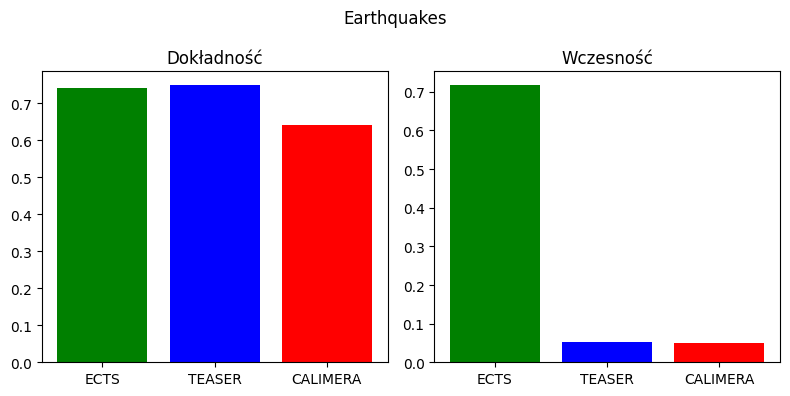

In [10]:
df_results = get_results_df()
visualize_results('Earthquakes', df_results)

### Zbiór danych ECG200

In [5]:
test_algorithms('ECG200')

Zbiór: ECG200
Długość: 96, Train: 100, Test: 100
  ECTS: acc=0.8600, earl=0.3760
  TEASER: acc=0.8300, earl=0.1010
  CALIMERA: acc=0.8500, earl=0.1057
  Naive_ECTS: acc=0.8100, earl=0.3760
  Naive_TEASER: acc=0.7400, earl=0.1010
  Naive_CALIMERA: acc=0.7700, earl=0.1057



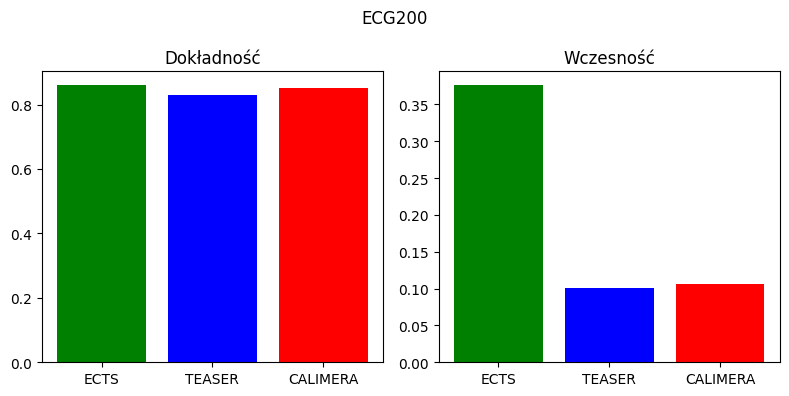

In [11]:
df_results = get_results_df()
visualize_results('ECG200', df_results)

### Zbiór danych Wine

In [6]:
test_algorithms('Wine')

Zbiór: Wine
Długość: 234, Train: 57, Test: 54
  ECTS: acc=0.6111, earl=0.4698
  TEASER: acc=0.5926, earl=0.0634
  CALIMERA: acc=0.6111, earl=0.1567
  Naive_ECTS: acc=0.5556, earl=0.4698
  Naive_TEASER: acc=0.4259, earl=0.0634
  Naive_CALIMERA: acc=0.4630, earl=0.1567



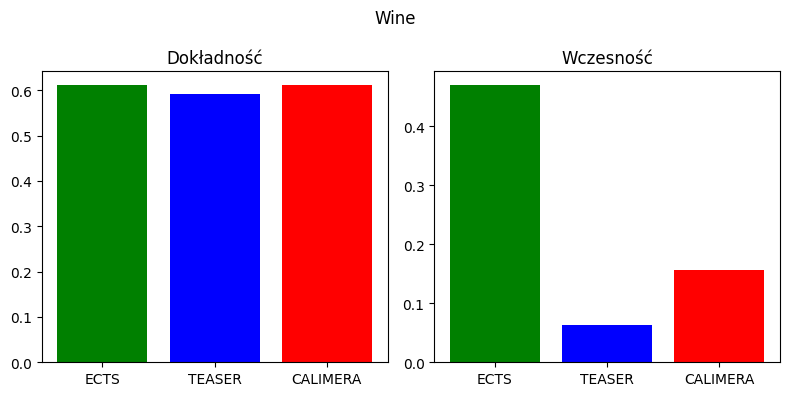

In [12]:
df_results = get_results_df()
visualize_results('Wine', df_results)

### Zbiór danych ECGFiveDays

In [7]:
test_algorithms('ECGFiveDays')

Zbiór: ECGFiveDays
Długość: 136, Train: 23, Test: 861
  ECTS: acc=0.7967, earl=0.7706
  TEASER: acc=0.7085, earl=0.1855
  CALIMERA: acc=0.7178, earl=0.1030
  Naive_ECTS: acc=0.7700, earl=0.7706
  Naive_TEASER: acc=0.6144, earl=0.1855
  Naive_CALIMERA: acc=0.6132, earl=0.1030



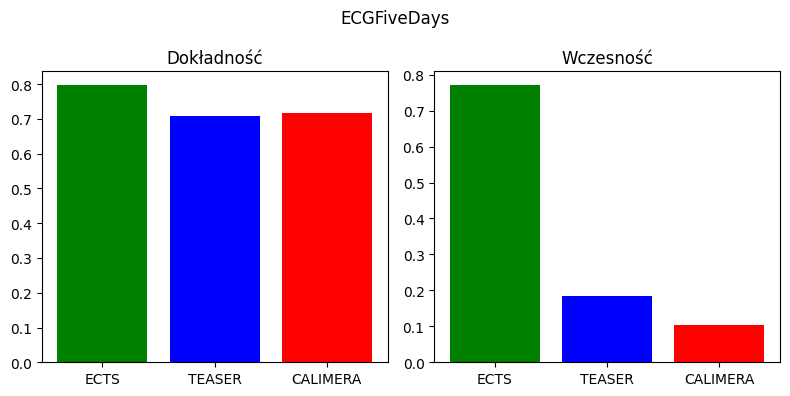

In [13]:
df_results = get_results_df()
visualize_results('ECGFiveDays', df_results)

### Zbiór danych Beef

In [8]:
test_algorithms('Beef')

Zbiór: Beef
Długość: 470, Train: 30, Test: 30
  ECTS: acc=0.6667, earl=0.7629
  TEASER: acc=0.8000, earl=0.0840
  CALIMERA: acc=0.6333, earl=0.0511
  Naive_ECTS: acc=0.6667, earl=0.7629
  Naive_TEASER: acc=0.4333, earl=0.0840
  Naive_CALIMERA: acc=0.4667, earl=0.0511



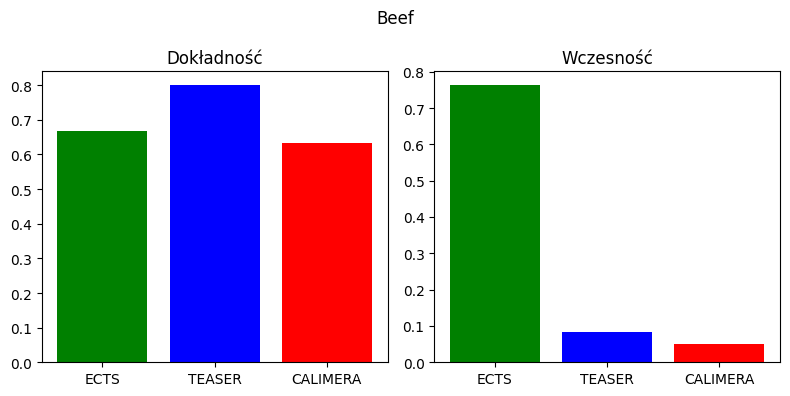

In [14]:
df_results = get_results_df()
visualize_results('Beef', df_results)

### Średnia harmoniczna

Średnia harmoniczna dla poszczególnych zbiorów:

ECTS:
  ECG200: 0.7232
  Earthquakes: 0.4094
  Wine: 0.5678
  ECGFiveDays: 0.3562
  Beef: 0.3498

TEASER:
  ECG200: 0.8631
  Earthquakes: 0.8358
  Wine: 0.7259
  ECGFiveDays: 0.7578
  Beef: 0.8541

CALIMERA:
  ECG200: 0.8716
  Earthquakes: 0.7647
  Wine: 0.7087
  ECGFiveDays: 0.7974
  Beef: 0.7597


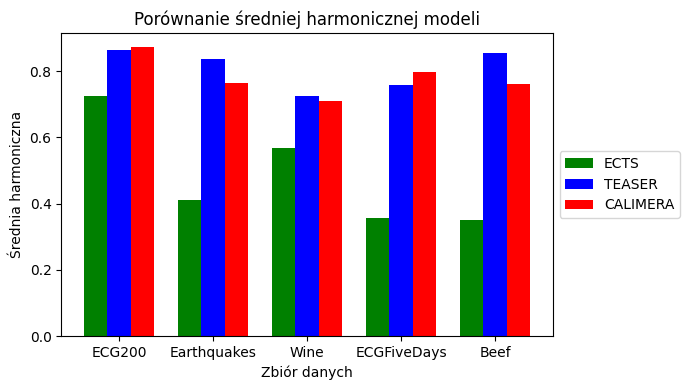

In [15]:
def hmean(a, e):
    """Oblicza średnią harmoniczną dokładności i wczesności"""
    return 2 * (1 - e) * a / ((1 - e) + a)

# Wybrane zbiory danych
selected_datasets = ['ECG200', 'Earthquakes', 'Wine', 'ECGFiveDays', 'Beef']
selected_data = df_results[df_results['dataset'].isin(selected_datasets)]

# Główne algorytmy
main_algorithms = ['ECTS', 'TEASER', 'CALIMERA']
selected_data = selected_data[selected_data['algorithm'].isin(main_algorithms)]

harmonic_means = {}
for algorithm in main_algorithms:
    alg_data = selected_data[selected_data['algorithm'] == algorithm]
    hmean_results = []
    
    for dataset in selected_datasets:
        dataset_data = alg_data[alg_data['dataset'] == dataset]
        if len(dataset_data) > 0:
            acc = dataset_data['accuracy'].values[0]
            earl = dataset_data['earliness'].values[0]
            hmean_val = hmean(acc, earl)
            hmean_results.append(hmean_val)
        else:
            hmean_results.append(0)
    
    harmonic_means[algorithm] = hmean_results

zb = selected_datasets
hm_e = harmonic_means['ECTS']
hm_t = harmonic_means['TEASER']
hm_c = harmonic_means['CALIMERA']

print("Średnia harmoniczna dla poszczególnych zbiorów:")
print("\nECTS:")
for i, dataset in enumerate(zb):
    print(f"  {dataset}: {hm_e[i]:.4f}")
print("\nTEASER:")
for i, dataset in enumerate(zb):
    print(f"  {dataset}: {hm_t[i]:.4f}")
print("\nCALIMERA:")
for i, dataset in enumerate(zb):
    print(f"  {dataset}: {hm_c[i]:.4f}")

x = np.arange(len(zb))
width = 0.25

fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(x - width, hm_e, width, label='ECTS', color='green')
ax.bar(x, hm_t, width, label='TEASER', color='blue')
ax.bar(x + width, hm_c, width, label='CALIMERA', color='red')
ax.set_ylabel('Średnia harmoniczna')
ax.set_xlabel('Zbiór danych')
ax.set_title('Porównanie średniej harmonicznej modeli')
ax.set_xticks(x)
ax.set_xticklabels(zb)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Wszystkie wyniki

In [16]:
print("Wszystkie wyniki:")
print(df_results.to_string(index=False))

Wszystkie wyniki:
    dataset      algorithm  accuracy  earliness
Earthquakes           ECTS  0.741007   0.717148
Earthquakes         TEASER  0.748201   0.053282
Earthquakes       CALIMERA  0.640288   0.050781
Earthquakes     Naive_ECTS  0.661871   0.717148
Earthquakes   Naive_TEASER  0.697842   0.053282
Earthquakes Naive_CALIMERA  0.697842   0.050781
     ECG200           ECTS  0.860000   0.376042
     ECG200         TEASER  0.830000   0.101042
     ECG200       CALIMERA  0.850000   0.105729
     ECG200     Naive_ECTS  0.810000   0.376042
     ECG200   Naive_TEASER  0.740000   0.101042
     ECG200 Naive_CALIMERA  0.770000   0.105729
       Wine           ECTS  0.611111   0.469769
       Wine         TEASER  0.592593   0.063390
       Wine       CALIMERA  0.611111   0.156695
       Wine     Naive_ECTS  0.555556   0.469769
       Wine   Naive_TEASER  0.425926   0.063390
       Wine Naive_CALIMERA  0.462963   0.156695
ECGFiveDays           ECTS  0.796748   0.770650
ECGFiveDays         TE

# Porównanie z naiwnymi klasyfikatorami

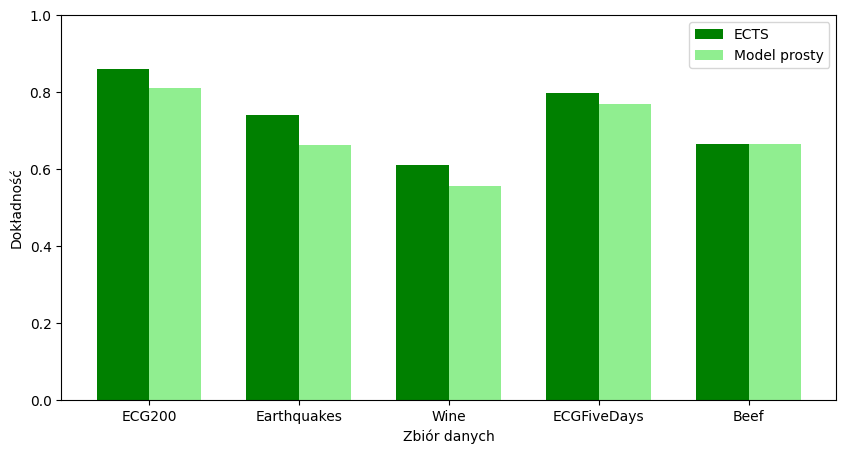

In [17]:
ects = []
baseline = []

for dataset in selected_datasets:
    # ECTS
    cal_data = df_results[(df_results['dataset'] == dataset) & (df_results['algorithm'] == 'ECTS')]
    if len(cal_data) > 0:
        ects.append(cal_data['accuracy'].values[0])
    else:
        ects.append(0)
    
    # Naive_ECTS
    naive_data = df_results[(df_results['dataset'] == dataset) & (df_results['algorithm'] == 'Naive_ECTS')]
    if len(naive_data) > 0:
        baseline.append(naive_data['accuracy'].values[0])
    else:
        baseline.append(0)

x = np.arange(len(selected_datasets))
width = 0.35
plt.figure(figsize=(10,5))
plt.bar(x - width/2, ects, width, label="ECTS", color="green")
plt.bar(x + width/2, baseline, width, label="Model prosty", color="lightgreen")
plt.xlabel("Zbiór danych")
plt.ylabel("Dokładność")
plt.xticks(x, selected_datasets)
plt.ylim(0, 1)
plt.legend()

plt.show()

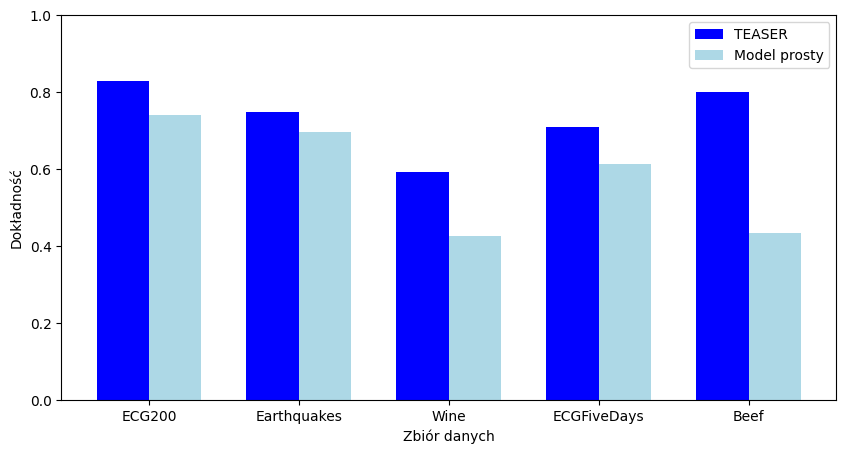

In [18]:
teaser = []
baseline = []

for dataset in selected_datasets:
    # TEASER
    cal_data = df_results[(df_results['dataset'] == dataset) & (df_results['algorithm'] == 'TEASER')]
    if len(cal_data) > 0:
        teaser.append(cal_data['accuracy'].values[0])
    else:
        teaser.append(0)
    
    # Naive_TEASER
    naive_data = df_results[(df_results['dataset'] == dataset) & (df_results['algorithm'] == 'Naive_TEASER')]
    if len(naive_data) > 0:
        baseline.append(naive_data['accuracy'].values[0])
    else:
        baseline.append(0)

x = np.arange(len(selected_datasets))
width = 0.35
plt.figure(figsize=(10,5))
plt.bar(x - width/2, teaser, width, label="TEASER", color="blue")
plt.bar(x + width/2, baseline, width, label="Model prosty", color="lightblue")
plt.xlabel("Zbiór danych")
plt.ylabel("Dokładność")
plt.xticks(x, selected_datasets)
plt.ylim(0, 1)
plt.legend()

plt.show()

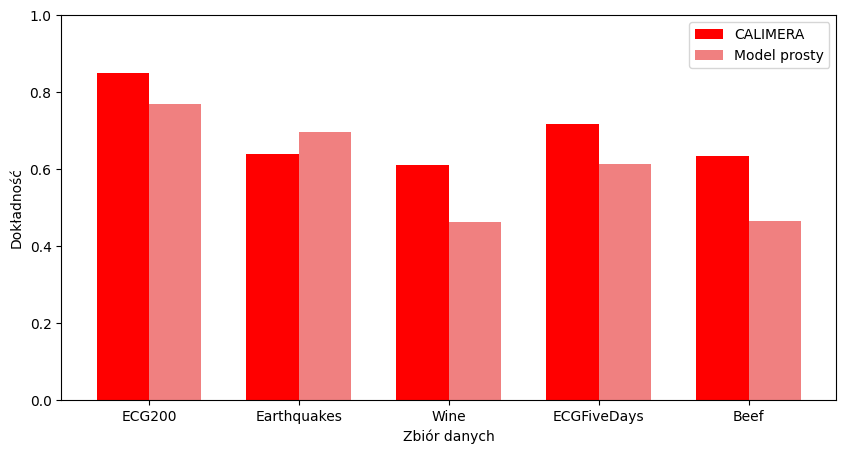

In [19]:
calimera = []
baseline = []

for dataset in selected_datasets:
    # CALIMERA
    cal_data = df_results[(df_results['dataset'] == dataset) & (df_results['algorithm'] == 'CALIMERA')]
    if len(cal_data) > 0:
        calimera.append(cal_data['accuracy'].values[0])
    else:
        calimera.append(0)
    
    # Naive_CALIMERA
    naive_data = df_results[(df_results['dataset'] == dataset) & (df_results['algorithm'] == 'Naive_CALIMERA')]
    if len(naive_data) > 0:
        baseline.append(naive_data['accuracy'].values[0])
    else:
        baseline.append(0)

x = np.arange(len(selected_datasets))
width = 0.35
plt.figure(figsize=(10,5))
plt.bar(x - width/2, calimera, width, label="CALIMERA", color="red")
plt.bar(x + width/2, baseline, width, label="Model prosty", color="lightcoral")
plt.xlabel("Zbiór danych")
plt.ylabel("Dokładność")
plt.xticks(x, selected_datasets)
plt.ylim(0, 1)
plt.legend()

plt.show()

# Badanie parametrów na zbiorze danych ECG200

In [20]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

ecg200_params_results = {}

def save_ecg200_result(algorithm, params, accuracy, earliness):
    """Zapisuje wynik badania parametrów dla ECG200"""
    key = (algorithm, str(params))
    ecg200_params_results[key] = {'accuracy': accuracy, 'earliness': earliness, 'params': params}
    print(f"  {algorithm} {params}: acc={accuracy:.4f}, earl={earliness:.4f}")

def test_ecg200_parameters():
    """Testuje wszystkie trzy algorytmy z różnymi parametrami dla ECG200"""
    print(f"{'='*60}")
    print(f"Badanie parametrów - Zbiór: ECG200")
    print(f"{'='*60}")
    
    # Wczytanie danych
    ucr = UCR_UEA_datasets()
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ucr.load_dataset('ECG200')
    X_train_sk, y_train_sk = load_UCR_UEA_dataset('ECG200', split="train")
    X_test_sk, y_test_sk = load_UCR_UEA_dataset('ECG200', split="test")
    max_length = X_train_ts.shape[1]
    
    X_train_df = pd.DataFrame(X_train_ts.squeeze())
    X_test_df = pd.DataFrame(X_test_ts.squeeze())
    labels = pd.Series(y_train_ts)
    step = max(1, max_length // 50)
    timestamps = list(range(0, max_length, step))
    if timestamps[-1] != max_length - 1:
        timestamps.append(max_length - 1)
    
    # ECTS 
    print("\n--- ECTS (4 wartości support) ---")
    support_values = [0.1, 0.3, 0.5, 1]
    for support in support_values:
        try:
            model = ECTS(timestamps=timestamps, support=support)
            model.train(X_train_df, labels)
            y_pred = model.predict(X_test_df)
            acc = accuracy_score(y_test_ts, [p[1] for p in y_pred])
            earl = np.mean([p[0] / max_length for p in y_pred])
            save_ecg200_result('ECTS', f'support_{support}', acc, earl)
        except Exception as e:
            print(f"  ECTS support={support} błąd: {e}")
    
    # TEASER 
    print("\n--- TEASER (3 estymatory + 3 jednoklasowe) ---")
    
    estimators = [
        None,  
        KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw"),
        KNeighborsTimeSeriesClassifier(n_neighbors=3, distance="dtw")
    ]
    
    one_class_estimators = [
        KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw"),
        KNeighborsTimeSeriesClassifier(n_neighbors=5, distance="dtw"),
        None  
    ]
    
    for i, estimator in enumerate(estimators):
        try:
            if estimator is None:
                clf = TEASER()
                param_name = "default_WEASEL"
            else:
                clf = TEASER(estimator=estimator)
                if hasattr(estimator, 'n_neighbors'):
                    param_name = f"KNN_n{estimator.n_neighbors}_dtw"
                else:
                    param_name = f"estimator_{i+1}"
            
            clf.fit(X_train_sk, y_train_sk)
            harm, acc, earl = clf.score(X_test_sk, y_test_sk)
            save_ecg200_result('TEASER', param_name, acc, earl)
        except Exception as e:
            param_name = "default_WEASEL" if estimator is None else (f"KNN_n{estimator.n_neighbors}_dtw" if hasattr(estimator, 'n_neighbors') else f"estimator_{i+1}")
            print(f"  TEASER {param_name} błąd: {e}")
    
    for i, estimator in enumerate(one_class_estimators):
        try:
            if estimator is None:
                clf = TEASER()  
                param_name = "oneclass_default_ocSVM"
            else:
                clf = TEASER(estimator=estimator)
                if hasattr(estimator, 'n_neighbors'):
                    param_name = f"oneclass_KNN_n{estimator.n_neighbors}_dtw"
                else:
                    param_name = f"oneclass_estimator_{i+1}"
            
            clf.fit(X_train_sk, y_train_sk)
            harm, acc, earl = clf.score(X_test_sk, y_test_sk)
            save_ecg200_result('TEASER', param_name, acc, earl)
        except Exception as e:
            param_name = "oneclass_default_ocSVM" if estimator is None else f"oneclass_estimator_{i+1}"
            print(f"  TEASER {param_name} błąd: {e}")
    
    # CALIMERA 
    print("\n--- CALIMERA (różne wartości alpha/delay_penalty) ---")
    X_train_cal = df_to_numpy(X_train_sk)
    X_test_cal = df_to_numpy(X_test_sk)
    
    alpha_values = [0.3, 0.5, 1.0, 1.5, 2.0]
    for alpha in alpha_values:
        try:
            model = CALIMERA(delay_penalty=alpha)
            model.fit(X_train_cal, y_train_sk)
            stop_ts, y_pred = model.test(X_test_cal)
            acc = accuracy_score(y_test_sk, y_pred)
            earl = np.mean([t / max_length for t in stop_ts])
            save_ecg200_result('CALIMERA', f'alpha_{alpha}', acc, earl)
        except Exception as e:
            print(f"  CALIMERA alpha={alpha} błąd: {e}")
    
    print()

test_ecg200_parameters()

Badanie parametrów - Zbiór: ECG200

--- ECTS (4 wartości support) ---
  ECTS support_0.1: acc=0.8600, earl=0.3459
  ECTS support_0.3: acc=0.8600, earl=0.3760
  ECTS support_0.5: acc=0.8600, earl=0.3760
  ECTS support_1: acc=0.8700, earl=0.4851

--- TEASER (3 estymatory + 3 jednoklasowe) ---
  TEASER default_WEASEL: acc=0.8300, earl=0.1010
  TEASER KNN_n1_dtw: acc=0.7700, earl=0.0668
  TEASER KNN_n3_dtw: acc=0.8300, earl=0.3277
  TEASER oneclass_KNN_n1_dtw: acc=0.7700, earl=0.0668
  TEASER oneclass_KNN_n5_dtw: acc=0.8400, earl=0.4741
  TEASER oneclass_default_ocSVM: acc=0.8300, earl=0.1010

--- CALIMERA (różne wartości alpha/delay_penalty) ---
  CALIMERA alpha_0.3: acc=0.8900, earl=0.2393
  CALIMERA alpha_0.5: acc=0.8800, earl=0.1786
  CALIMERA alpha_1.0: acc=0.8600, earl=0.1026
  CALIMERA alpha_1.5: acc=0.8300, earl=0.0906
  CALIMERA alpha_2.0: acc=0.8300, earl=0.0807



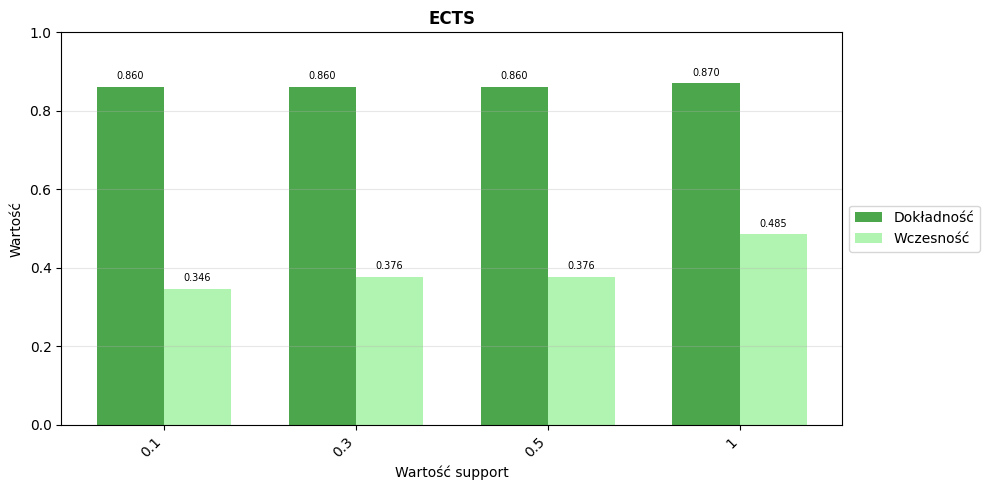

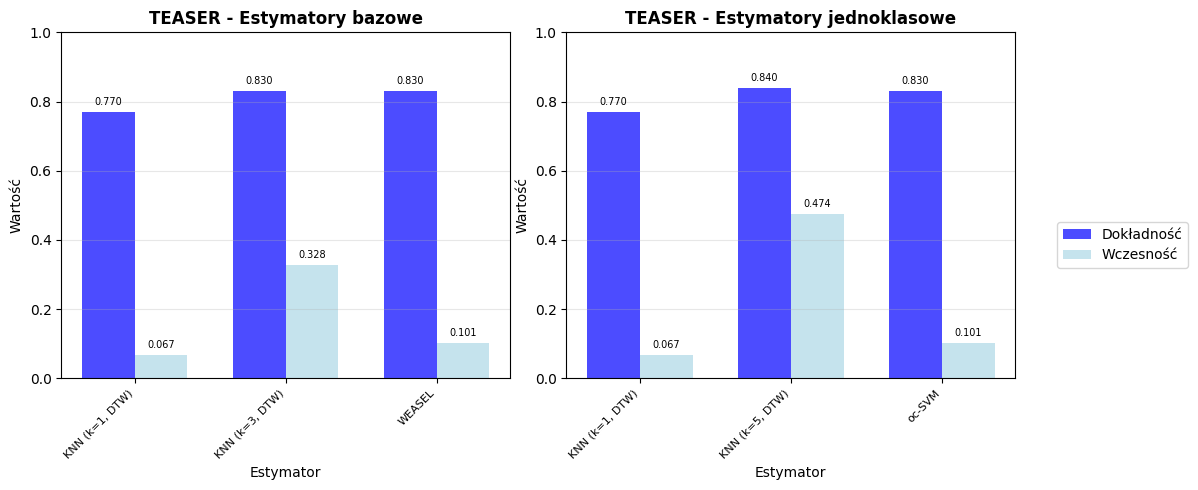

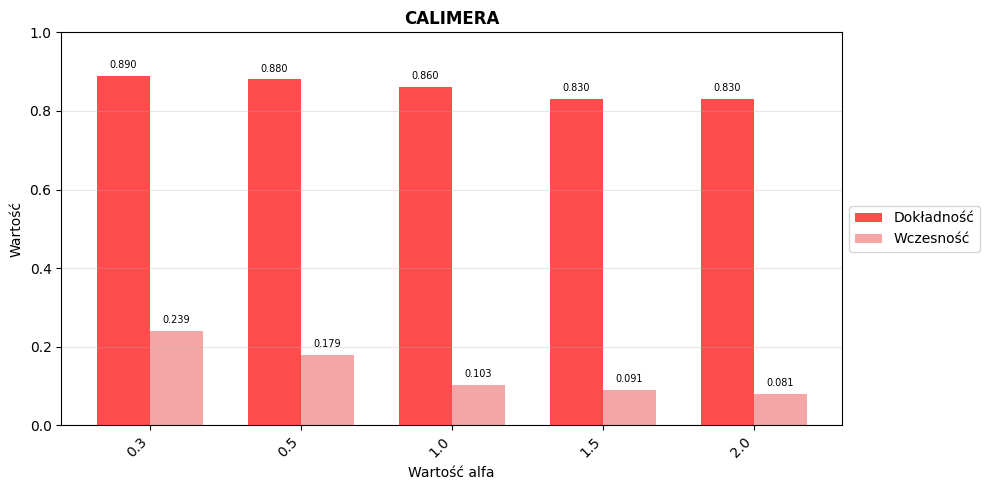

In [21]:
# Wizualizacja wyników badania parametrów dla ECG200
def visualize_ecg200_params():
    """Tworzy wizualizację wyników parametrów dla ECG200 z konwencją kolorystyczną"""
    ects_data = []
    teaser_data = []
    calimera_data = []
    
    for (algorithm, params_str), vals in ecg200_params_results.items():
        if algorithm == 'ECTS':
            ects_data.append({
                'params': vals['params'],
                'accuracy': vals['accuracy'],
                'earliness': vals['earliness']
            })
        elif algorithm == 'TEASER':
            teaser_data.append({
                'params': vals['params'],
                'accuracy': vals['accuracy'],
                'earliness': vals['earliness']
            })
        elif algorithm == 'CALIMERA':
            calimera_data.append({
                'params': vals['params'],
                'accuracy': vals['accuracy'],
                'earliness': vals['earliness']
            })
    
    ects_data.sort(key=lambda x: float(x['params'].split('_')[1]) if '_' in x['params'] else 0)
    teaser_data.sort(key=lambda x: x['params'])
    calimera_data.sort(key=lambda x: float(x['params'].split('_')[1]) if '_' in x['params'] else 0)
    
    # ECTS 
    if len(ects_data) > 0:
        ects_params = [d['params'] for d in ects_data]
        ects_acc = [d['accuracy'] for d in ects_data]
        ects_earl = [d['earliness'] for d in ects_data]
        
        x = np.arange(len(ects_data))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(x - width/2, ects_acc, width, label='Dokładność', color='green', alpha=0.7)
        ax.bar(x + width/2, ects_earl, width, label='Wczesność', color='lightgreen', alpha=0.7)
        ax.set_title('ECTS', fontsize=12, fontweight='bold')
        ax.set_xlabel('Wartość support', fontsize=10)
        ax.set_ylabel('Wartość', fontsize=10)
        ax.set_ylim(0, 1)
        ax.set_xticks(x)
        ax.set_xticklabels([p.split('_')[1] if '_' in p else p for p in ects_params], rotation=45, ha='right')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(axis='y', alpha=0.3)
        for i, (acc, earl) in enumerate(zip(ects_acc, ects_earl)):
            ax.text(i - width/2, acc + 0.02, f'{acc:.3f}', ha='center', fontsize=7)
            ax.text(i + width/2, earl + 0.02, f'{earl:.3f}', ha='center', fontsize=7)
        plt.tight_layout()
        plt.show()
    
     # TEASER 
    if len(teaser_data) > 0:
        def format_teaser_label(param_name):
            if param_name == 'default_WEASEL':
                return 'WEASEL'
            elif param_name.startswith('KNN_n'):
                parts = param_name.split('_')
                k_value = parts[1].replace('n', '')
                return f'KNN (k={k_value}, DTW)'
            elif param_name == 'default_ocSVM':
                return 'oc-SVM'
            else:
                return param_name
        
        teaser_basic = [d for d in teaser_data if not d['params'].startswith('oneclass_')]
        teaser_oneclass = [d for d in teaser_data if d['params'].startswith('oneclass_')]
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        if len(teaser_basic) > 0:
            basic_params = [d['params'] for d in teaser_basic]
            basic_labels = [format_teaser_label(p) for p in basic_params]
            basic_acc = [d['accuracy'] for d in teaser_basic]
            basic_earl = [d['earliness'] for d in teaser_basic]
            
            x = np.arange(len(teaser_basic))
            width = 0.35
            
            axes[0].bar(x - width/2, basic_acc, width, label='Dokładność', color='blue', alpha=0.7)
            axes[0].bar(x + width/2, basic_earl, width, label='Wczesność', color='lightblue', alpha=0.7)
            axes[0].set_title('TEASER - Estymatory bazowe', fontsize=12, fontweight='bold')
            axes[0].set_xlabel('Estymator', fontsize=10)
            axes[0].set_ylabel('Wartość', fontsize=10)
            axes[0].set_ylim(0, 1)
            axes[0].set_xticks(x)
            axes[0].set_xticklabels(basic_labels, rotation=45, ha='right', fontsize=8)
            axes[0].grid(axis='y', alpha=0.3)
            for i, (acc, earl) in enumerate(zip(basic_acc, basic_earl)):
                axes[0].text(i - width/2, acc + 0.02, f'{acc:.3f}', ha='center', fontsize=7)
                axes[0].text(i + width/2, earl + 0.02, f'{earl:.3f}', ha='center', fontsize=7)
        else:
            axes[0].axis('off')
            axes[0].text(0.5, 0.5, 'Brak danych', ha='center', va='center', fontsize=12)
        
        if len(teaser_oneclass) > 0:
            oneclass_params = [d['params'].replace('oneclass_', '') for d in teaser_oneclass]
            oneclass_labels = [format_teaser_label(p) for p in oneclass_params]
            oneclass_acc = [d['accuracy'] for d in teaser_oneclass]
            oneclass_earl = [d['earliness'] for d in teaser_oneclass]
            
            x = np.arange(len(teaser_oneclass))
            width = 0.35
            
            axes[1].bar(x - width/2, oneclass_acc, width, label='Dokładność', color='blue', alpha=0.7)
            axes[1].bar(x + width/2, oneclass_earl, width, label='Wczesność', color='lightblue', alpha=0.7)
            axes[1].set_title('TEASER - Estymatory jednoklasowe', fontsize=12, fontweight='bold')
            axes[1].set_xlabel('Estymator', fontsize=10)
            axes[1].set_ylabel('Wartość', fontsize=10)
            axes[1].set_ylim(0, 1)
            axes[1].set_xticks(x)
            axes[1].set_xticklabels(oneclass_labels, rotation=45, ha='right', fontsize=8)
            axes[1].grid(axis='y', alpha=0.3)
            for i, (acc, earl) in enumerate(zip(oneclass_acc, oneclass_earl)):
                axes[1].text(i - width/2, acc + 0.02, f'{acc:.3f}', ha='center', fontsize=7)
                axes[1].text(i + width/2, earl + 0.02, f'{earl:.3f}', ha='center', fontsize=7)
        else:
            axes[1].axis('off')
            axes[1].text(0.5, 0.5, 'Brak danych', ha='center', va='center', fontsize=12)
        
        handles, labels = axes[0].get_legend_handles_labels()
        if len(handles) == 0 and len(teaser_oneclass) > 0:
            handles, labels = axes[1].get_legend_handles_labels()
        if len(handles) > 0:
            fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1, 0.5), fontsize=10)
        
        plt.tight_layout()
        plt.subplots_adjust(right=0.85)
        plt.show()

    # CALIMERA 
    if len(calimera_data) > 0:
        calimera_params = [d['params'] for d in calimera_data]
        calimera_acc = [d['accuracy'] for d in calimera_data]
        calimera_earl = [d['earliness'] for d in calimera_data]
        
        x = np.arange(len(calimera_data))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(x - width/2, calimera_acc, width, label='Dokładność', color='red', alpha=0.7)
        ax.bar(x + width/2, calimera_earl, width, label='Wczesność', color='lightcoral', alpha=0.7)
        ax.set_title('CALIMERA', fontsize=12, fontweight='bold')
        ax.set_xlabel('Wartość alfa', fontsize=10)
        ax.set_ylabel('Wartość', fontsize=10)
        ax.set_ylim(0, 1)
        ax.set_xticks(x)
        ax.set_xticklabels([p.split('_')[1] if '_' in p else p for p in calimera_params], rotation=45, ha='right')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(axis='y', alpha=0.3)
        for i, (acc, earl) in enumerate(zip(calimera_acc, calimera_earl)):
            ax.text(i - width/2, acc + 0.02, f'{acc:.3f}', ha='center', fontsize=7)
            ax.text(i + width/2, earl + 0.02, f'{earl:.3f}', ha='center', fontsize=7)
        plt.tight_layout()
        plt.show()

visualize_ecg200_params()